In [9]:
# Analysis of Ad performance dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Data-processing

All data-analysis start with data processing, looking at the dataset and it's features

In [ ]:
# Load data
file_path = 'Ad Performance Dataset.xlsx'
app_data = pd.read_excel(file_path, sheet_name = 'App Data')
ad_data = pd.read_excel(file_path, sheet_name = 'Ad Data')

# Standardise for robustness
app_data['Date'] = pd.to_datetime(app_data['Date'])
ad_data['Date'] = pd.to_datetime(ad_data['Date'])

# Merge the datasets through left join to keep all the pre-campaign data
df = pd.merge(app_data, ad_data, on = 'Date', how = 'left')

# Data Cleaning
# We fill 'Ad spend' and 'Paid downloads' with 0 for the pre-campaign period for visuals
df['Ad spend'] = df['Ad spend'].fillna(0)
df['Paid downloads'] = df['Paid downloads'].fillna(0)

# Feature Engineering custom metrics for analysis
df['Daily Net Profit'] = df['Revenue'] - df['Ad spend']
df['Is Profit Day'] = (df['APPD (on paid downloads)'] >= 0).astype(float)

# Export cleaned data
df.to_csv('cleaned_campaign_data.csv', index = False)

In [81]:
# Find relevant stats
campaign_df = df[df['Date'] >= pd.to_datetime('2014-10-07')].copy()
pre_campaign_df = df[df['Date'] < pd.to_datetime('2014-10-07')].copy()

# Total statistics
total_cost = campaign_df['Ad spend'].sum()
total_revenue = campaign_df['Revenue'].sum()
total_profit = total_revenue - total_cost

# Pre-campaign statistics
avg_downloads_pre = pre_campaign_df['Total downloads'].mean()
avg_organic_pre = pre_campaign_df['Organic downloads'].mean()
avg_profit_pre = pre_campaign_df['Daily Net Profit'].mean()

# Campaign statistics
avg_downloads_camp = campaign_df['Total downloads'].mean()
avg_organic_camp = campaign_df['Organic downloads'].mean()
avg_profit_camp = campaign_df['Daily Net Profit'].mean()

# Impact
impact_downloads = avg_downloads_camp / avg_downloads_pre
impact_organic = avg_organic_camp / avg_organic_pre
impact_profit = avg_profit_camp / avg_profit_pre

# 5. Print Results in a clean format
print("DAILY STATS")
print(f"Daily Downloads:      Pre: {avg_downloads_pre:.0f} | Camp: {avg_downloads_camp:,.0f} | Impact: {impact_downloads:.0f}x")
print(f"Daily Organic:        Pre: {avg_organic_pre:.0f} | Camp: {avg_organic_camp:,.0f} | Impact: {impact_organic:.0f}x")
print(f"Daily Net Profit:     Pre: ${avg_profit_pre:.2f} | Camp: ${avg_profit_camp:,.2f} | Impact: {impact_profit:.0f}x")
print("CAMPAIGN STATS")
print(f"Total Cost:          ${total_cost:,.2f}")
print(f"Total App Revenue:   ${total_revenue:,.2f}")
print(f"Net Campaign Profit: ${total_profit:,.2f}")
print(f"Avg. Cost per User:  ${campaign_df['CPI'].mean():.3f}")

DAILY STATS
Daily Downloads:      Pre: 13 | Camp: 2,268 | Impact: 180x
Daily Organic:        Pre: 13 | Camp: 855 | Impact: 68x
Daily Net Profit:     Pre: $1.08 | Camp: $111.38 | Impact: 103x
CAMPAIGN STATS
Total Cost:          $7,563.00
Total App Revenue:   $17,141.79
Net Campaign Profit: $9,578.79
Avg. Cost per User:  $0.068


In [25]:
print(len(campaign_df))
print(len(pre_campaign_df))


86
67


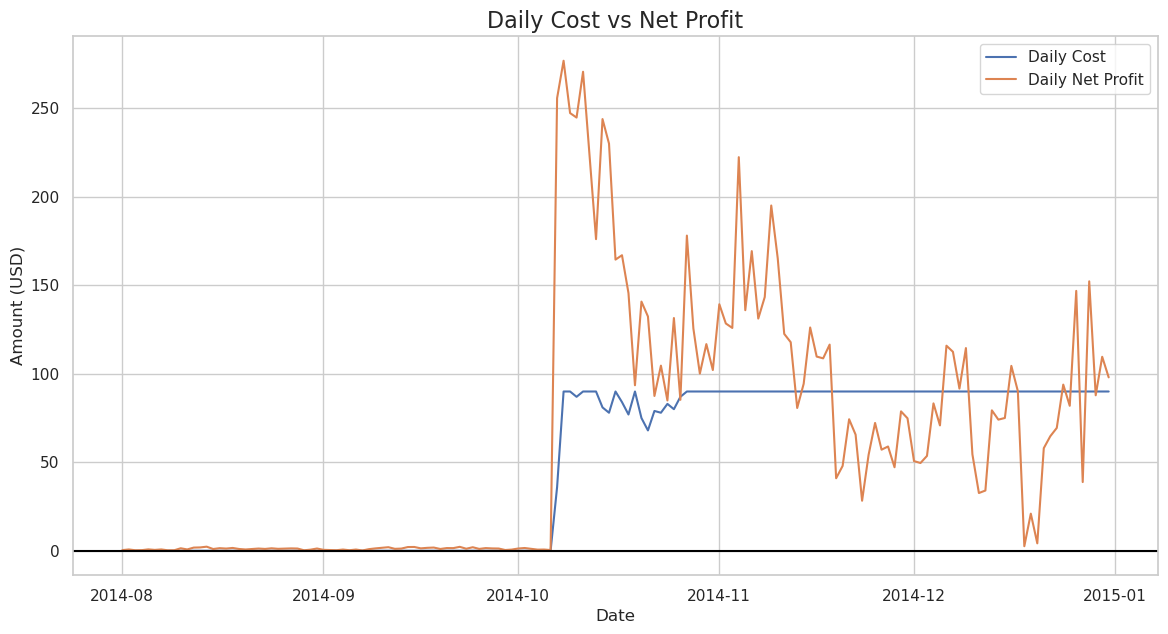

In [ ]:
# Plot
plt.figure(figsize = (14, 7))

# Plot Daily Cost ie Ad Spend
plt.plot(df['Date'], df['Ad spend'], label = 'Daily Cost')

# Plot Daily Net Profit
plt.plot(df['Date'], df['Daily Net Profit'], label = 'Daily Net Profit')

# Add formatting and context
plt.axhline(y = 0, color = 'black')

plt.title('Daily Cost vs Net Profit', fontsize = 14)
plt.xlabel('Date')
plt.ylabel('Amount (USD)')
plt.legend()
plt.show()

Economics Stats
           CPI  ARPD (on paid downloads)  APPD (on paid downloads)
mean  0.067826                  0.090465                   0.02264
min   0.026000                  0.038000                  -0.04800
max   0.105000                  0.134000                   0.07400


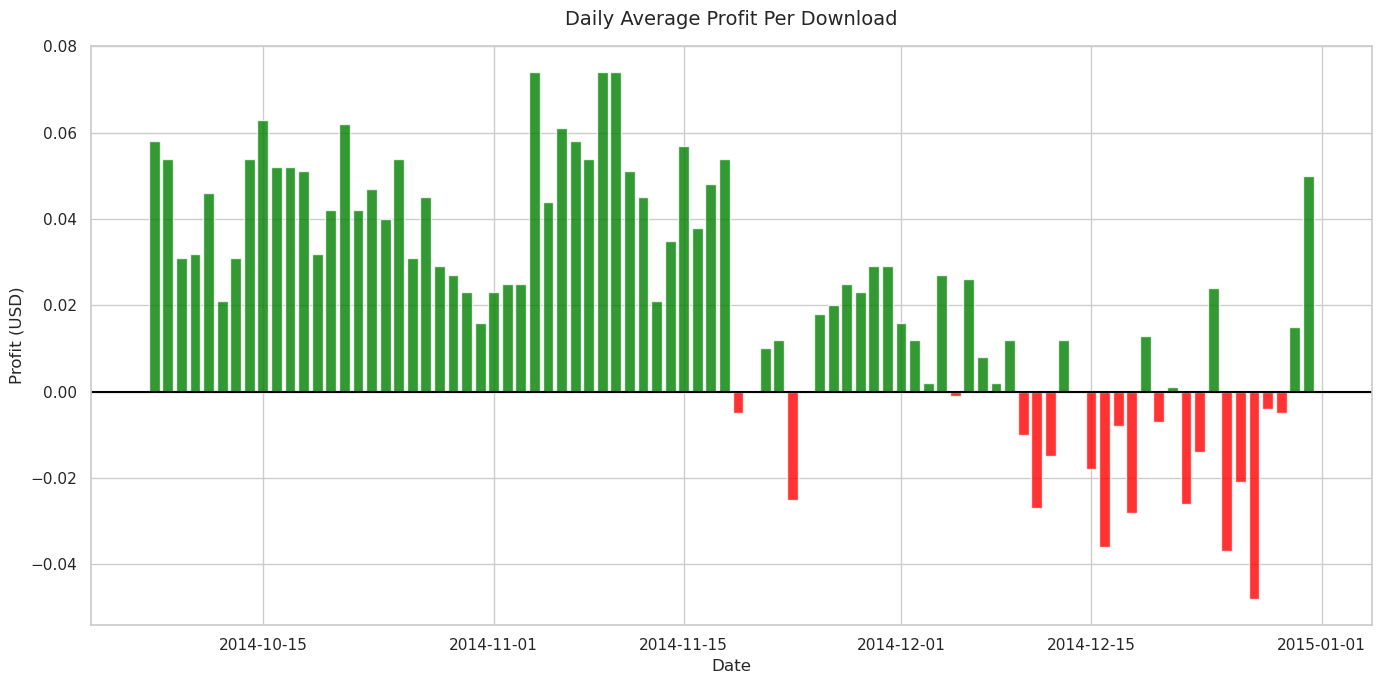

In [45]:
# Key Stats
print("Economics Stats")
print(campaign[['CPI', 'ARPD (on paid downloads)', 'APPD (on paid downloads)']].describe().loc[['mean', 'min', 'max']])


# Chart showing the Average Profit Per Download (APPD)
plt.figure(figsize = (14, 7))

# Create bars with conditional coloring
plt.bar(campaign['Date'], campaign['APPD (on paid downloads)'], 
        color = ['green' if x >= 0 else 'red' for x in campaign['APPD (on paid downloads)']],
        alpha = 0.8)

plt.axhline(y = 0, color = 'black')

plt.title('Daily Average Profit Per Download', fontsize = 14, pad = 15)
plt.ylabel('Profit (USD)')
plt.xlabel('Date')

# Use a tight layout to prevent clipping
plt.tight_layout()
plt.show()

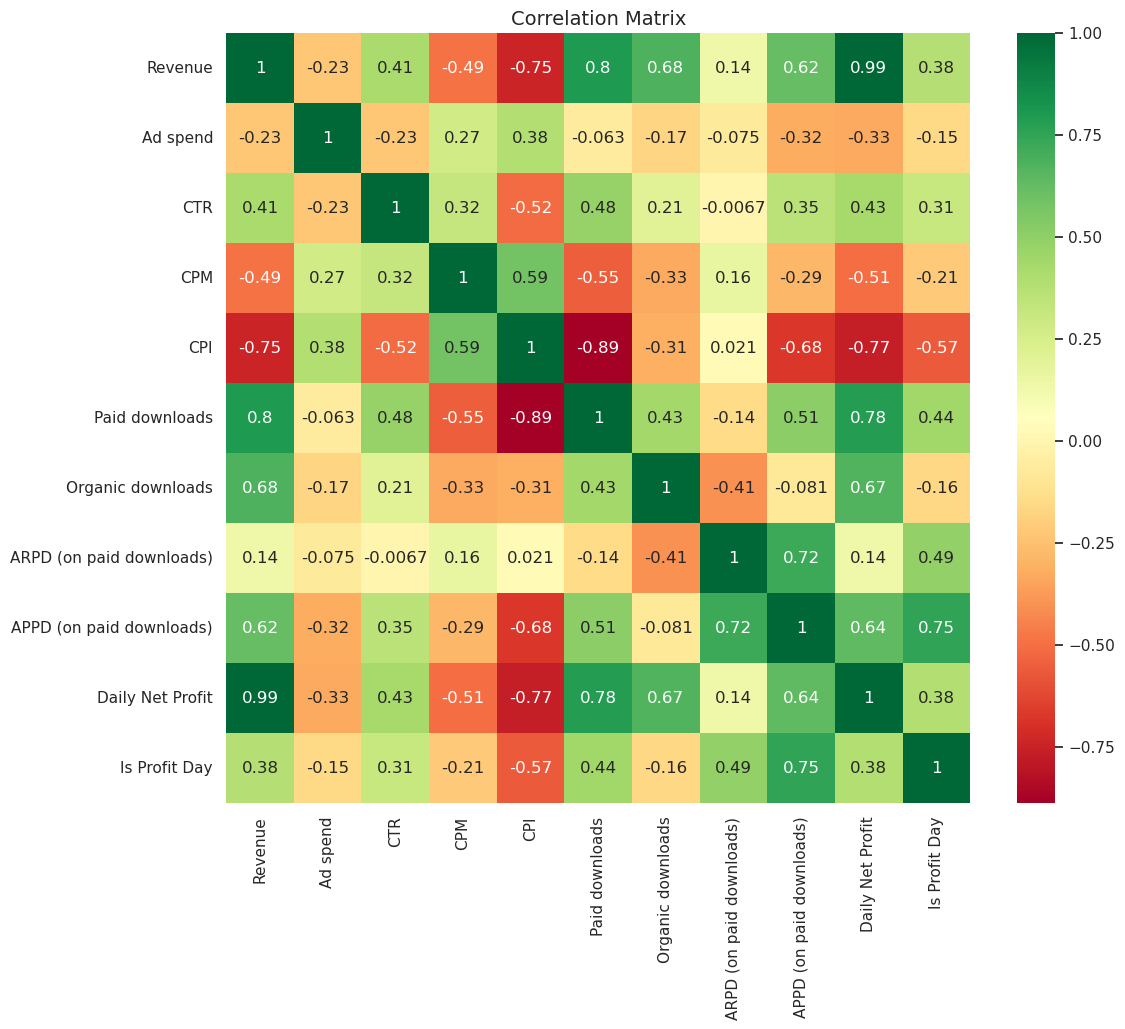

In [54]:
# Select columns to analyze
cols = [
    'Revenue', 'Ad spend', 'CTR', 'CPM', 'CPI', 
    'Paid downloads', 'Organic downloads', 
    'ARPD (on paid downloads)', 'APPD (on paid downloads)', 
    'Daily Net Profit', 'Is Profit Day'
]

# Calculate the correlation and plot
plt.figure(figsize = (12, 10))
sns.heatmap(campaign_df[cols].corr(), annot = True, cmap = 'RdYlGn')
plt.title('Correlation Matrix', fontsize = 14)
plt.show()

Probability of Profit by CPI Level
CPI Bucket
(0.0, 0.05]     100.000000
(0.05, 0.07]     96.774194
(0.07, 0.09]     66.666667
(0.09, 0.11]     30.769231
Name: APPD (on paid downloads), dtype: float64


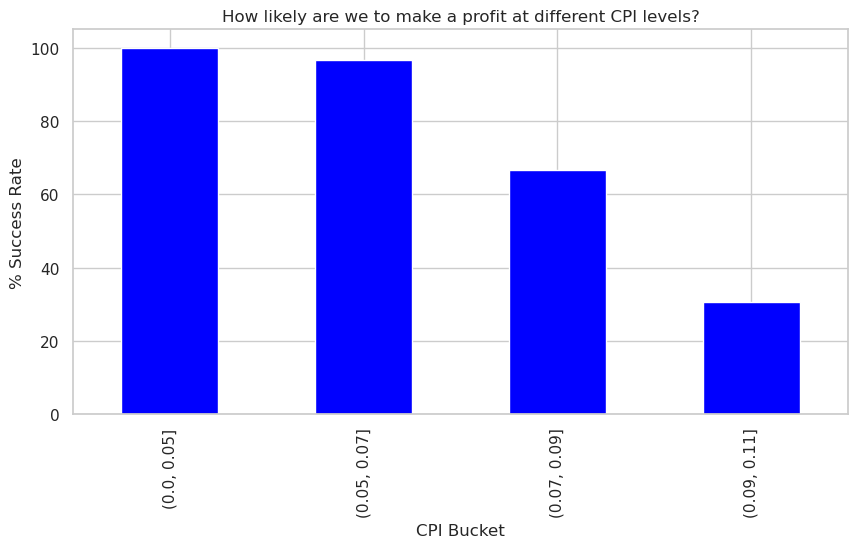

In [82]:
# Create brackets for CPI to calculate the probability of being profitable
campaign_df['CPI Bucket'] = pd.cut(campaign_df['CPI'], bins = [0, 0.05, 0.07, 0.09, 0.11])

# Calculate % of days that were profitable based on APPD
success_rate = campaign_df.groupby('CPI Bucket', observed = True)['APPD (on paid downloads)'].apply(lambda x: (x >= 0).mean() * 100)

print("Probability of Profit by CPI Level")
print(success_rate)

# Visualization of the Success Rate
success_rate.plot(kind = 'bar', color = 'blue', figsize = (10,5))
plt.title('How likely are we to make a profit at different CPI levels?')
plt.ylabel('% Success Rate')
plt.show()

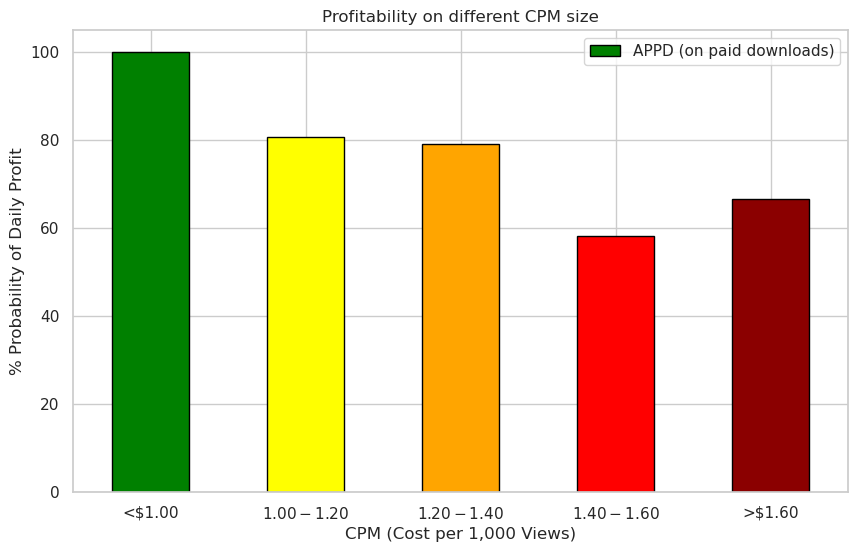

In [83]:
cpm_bins = [0, 1.0, 1.2, 1.4, 1.6, 2.5]
cpm_labels = ['<$1.00', '$1.00-$1.20', '$1.20-$1.40', '$1.40-$1.60', '>$1.60']
campaign_df['CPM Bucket'] = pd.cut(campaign_df['CPM'], bins = cpm_bins, labels = cpm_labels)

# Calculate the % of days that were profitable based on APPD
# We group by the bucket and find the mean of a True/False statement
success_rate = campaign_df.groupby('CPM Bucket', observed = True)['APPD (on paid downloads)'].apply(lambda x: (x >= 0).mean() * 100)

# Visualization
plt.figure(figsize = (10, 6))
colors = ['green', 'yellow', 'orange', 'red', 'darkred']
success_rate.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Profitability on different CPM size')
plt.ylabel('% Probability of Daily Profit')
plt.xlabel('CPM (Cost per 1,000 Views)')
plt.xticks(rotation = 0)
plt.legend()
plt.show()

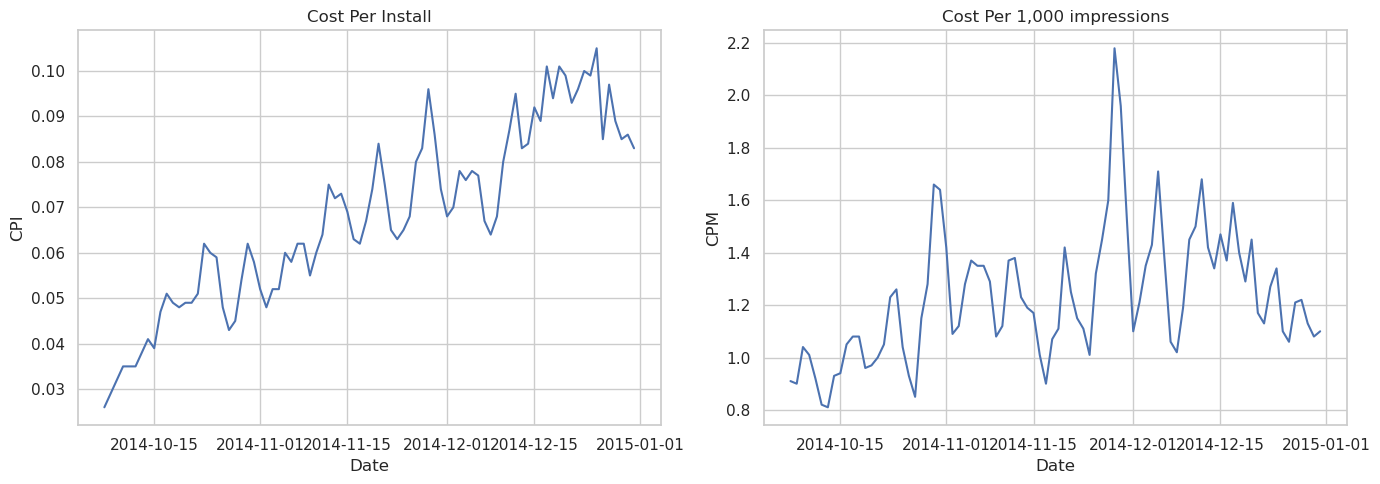

In [84]:
# Set theme
sns.set_theme(style = "whitegrid")

# Create a 1x2 grid (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot directly onto the 1D axes
sns.lineplot(data = campaign_df, x = 'Date', y = 'CPI', ax = axes[0]).set_title('Cost Per Install')
sns.lineplot(data = campaign_df, x = 'Date', y = 'CPM', ax = axes[1]).set_title('Cost Per 1,000 impressions')
plt.tight_layout()
plt.show()

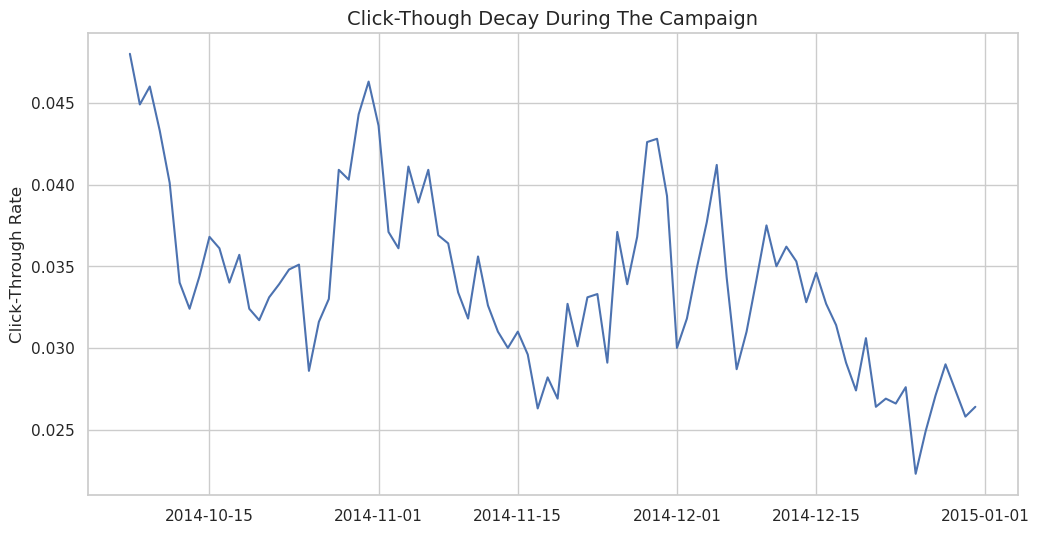

In [ ]:
# Plot CTR over time with a Trend Line
plt.figure(figsize = (12, 6))
plt.plot(campaign_df['Date'], campaign_df['CTR'])
plt.title('Click-Though Decay During The Campaign', fontsize = 14)
plt.ylabel('Click-Through Rate')
plt.show()

In [88]:
# Overall CTR average
ctr_average = campaign_df['CTR'].mean()

# CTR average towards the end
end_avg = campaign_df['CTR'].iloc[-14:].mean()

print(f"CTR average: {ctr_average:.2%}")
print(f"Last two weeks average: {end_avg:.2%}")

CTR average: 3.40%
Last two weeks average: 2.70%


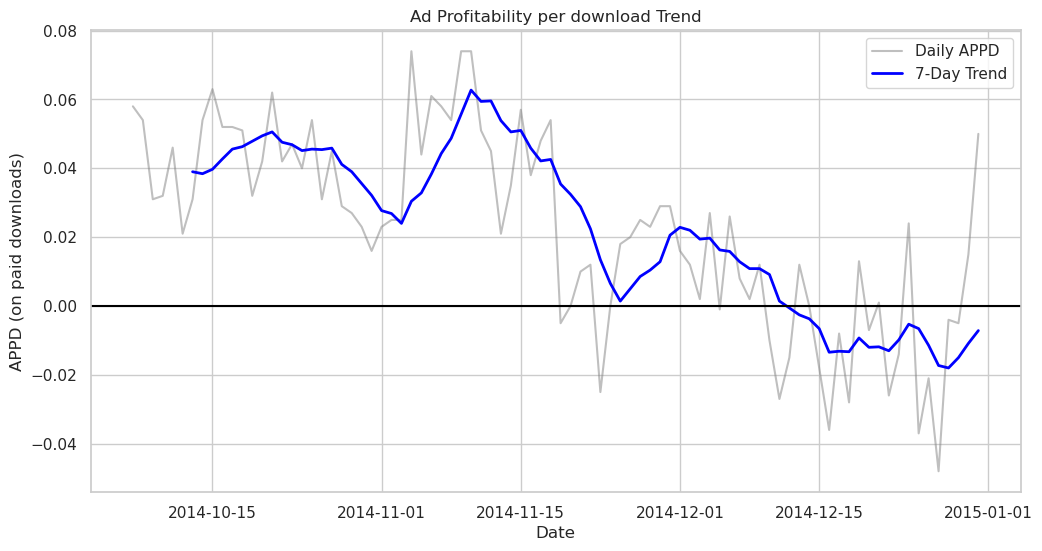

In [ ]:
# Calculate the trend line
campaign_df['7D_Avg'] = campaign_df['APPD (on paid downloads)'].rolling(7).mean()

# Plot 
sns.set_theme(style = "whitegrid")
plt.figure(figsize = (12, 6))

sns.lineplot(data = campaign_df, x = 'Date', y = 'APPD (on paid downloads)', color = 'gray', alpha = 0.5, label = 'Daily APPD')
sns.lineplot(data = campaign_df, x = 'Date', y = '7D_Avg', color = 'blue', linewidth = 2, label = '7-Day Trend')

# add formatting
plt.axhline(y = 0, color = 'black')
plt.title('Ad Profitability Per Download Trend')
plt.show()